# LTSP - Gridded product
**AODNE assistance** - ifo at aodn dot org dot au

2020-01-21


This notebook shows how to work with the gridded product. This particular product aggregates `TEMP` where two or more measurements are available for the same timestamp at one particular site. the aggregation is done by (linearly) interpolating the available values to a user specified target depths.

The structure of the aggregated file is a rectangular array with `TIME` and `DEPTH` as dimensions. The timestamps are fixed to 1-hour intervals and the depth bin are defined by the user, but always between the min/max depth of the all deployments of the mooring array. The "gridded" data files are available in the "gridded_timeseries" directory in each sub-facility director at [AODN THREDDS server](http://thredds.aodn.org.au/thredds/catalog/IMOS/)

The aggregation uses the [Hourly aggregated LTSP](https://github.com/aodn/python-aodntools/tree/master/aodntools/timeseries_products) as input.

![](images/PH100_availability.png)

## The structure of the file

The gridded data is organised in a rectangular array (yeah!):


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [10]:
fileName = "http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/PH100/gridded_timeseries/IMOS_ANMN-NSW_TZ_20091029_PH100_FV02_TEMP-gridded-timeseries_END-20190828_C-20200108.nc"
nc = xr.open_dataset(fileName)
nc

<xarray.Dataset>
Dimensions:     (DEPTH: 22, TIME: 83946)
Coordinates:
  * DEPTH       (DEPTH) float64 5.0 10.0 15.0 20.0 ... 95.0 100.0 105.0 110.0
  * TIME        (TIME) datetime64[ns] 2009-10-29T02:00:00 ... 2019-08-28T01:00:00
Data variables:
    TEMP_count  (TIME) int32 ...
    LATITUDE    float64 ...
    LONGITUDE   float64 ...
    TEMP        (TIME, DEPTH) float64 ...
Attributes:
    Conventions:                 CF-1.6,IMOS-1.4
    abstract:                    Gridded Time Series Product: This file conta...
    acknowledgement:             Any users of IMOS data are required to clear...
    author:                      Klein, Eduardo
    author_email:                eduardo.kleinsalas@utas.edu.au
    citation:                    The citation in a list of references is: "IM...
    contributor_email:           mroughan@unsw.edu.au; t.austin@unsw.edu.au
    contributor_name:            Roughan, Moninya; Austin, Timothy
    contributor_role:            principal_investigator; author

This particular file has been gridded into 12 target depths:

In [4]:
bins = list(nc.DEPTH.values)
print(bins)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0]


and `TEMP` is obtained from +83K hourly timestamps. 

Due to the nature of the deployments, the gridded file naturally contains gaps in the data: 



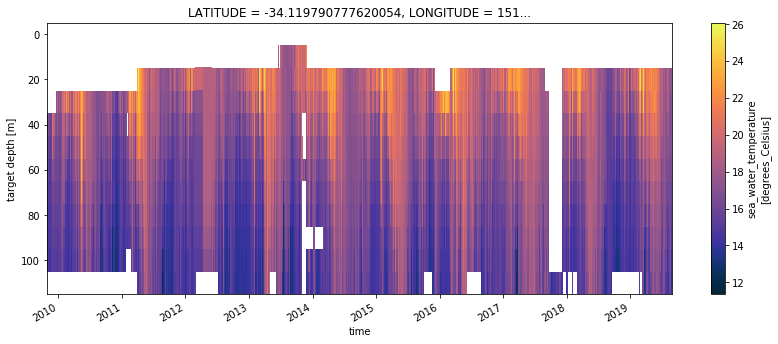

In [5]:
import cmocean.cm as cmo   ## let's use the cmocean color maps https://matplotlib.org/cmocean/
nc.TEMP.plot.pcolormesh(x='TIME', y='DEPTH', yincrease=False, figsize=(14,5), cmap=cmo.thermal)


Also, the previous plot is misleading, as it appears that we're making a **profile** by depth, but what we really have is a set of **time series interpolated at target depths**: 

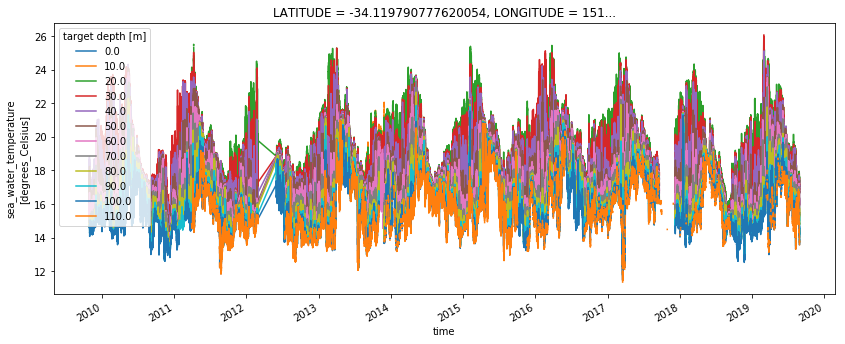

In [6]:
nc.TEMP.plot(hue='DEPTH', add_legend=True, figsize=(14,5))



It is possible to plot a time series at each particular interpolated depth (note that the first target depth contains no data, so the mean operation will raise a warning): 


In [7]:
print(bins)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0]


In [9]:

## calculate de mean TEMP at each target depth
nc.TEMP.groupby('DEPTH').mean(dim='TIME')

/home/eklein/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'TEMP' (DEPTH: 12)>
array([      nan, 19.253392, 19.718827, 19.13572 , 18.342259, 17.675377,
       17.122891, 16.666336, 16.259566, 15.932791, 15.646375, 15.523681])
Coordinates:
  * DEPTH      (DEPTH) float64 0.0 10.0 20.0 30.0 40.0 ... 80.0 90.0 100.0 110.0
    LATITUDE   float64 ...
    LONGITUDE  float64 ...



### PLOT a time series at particular depth

So, having the data interpolated a particular depth makes it very easy to plot a TEMP time series at depth of interest. Say, for example, we want the TEMP timeseries at 20, 30, 50 and 100m depth:

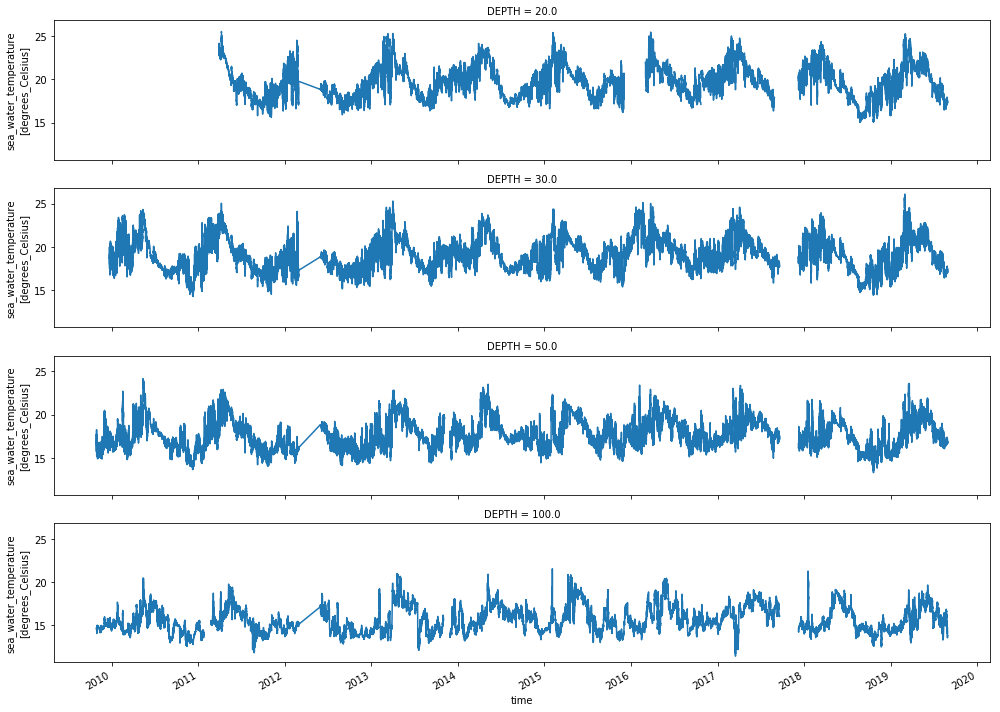

In [50]:
nc.TEMP.sel(DEPTH=[20, 30, 50, 100]).plot.line(x='TIME', row='DEPTH', figsize=(14,10))

### Playing with the data.

With this aggregated dataset it is more easy to analyse the observed values. For example, let's check the correlation between the TEMP timeseries among all interpolated depth. This will give us a glimpse of similar regions in the water column (idea and code suggested by Hugo Oliveira at IMOS-AODN)

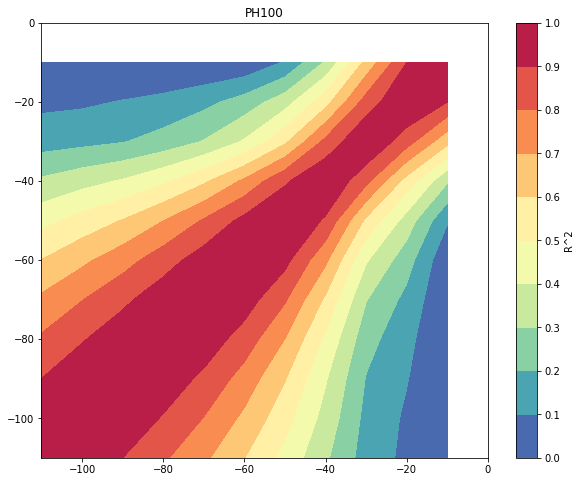

In [131]:
## get values
depth = -nc.DEPTH.values
temp = nc.TEMP.values

## make a dataframe
df = pd.DataFrame(temp)

## calculate the squared correlation coefficient
r2 = df.corr()**2

## plot the correlation matrix as a filled contour
levels =  np.linspace(0,1,11)
plt.figure(figsize=(10,8))
plt.contourf(depth,depth,r2, cmap='Spectral_r', levels=levels)
cbar = plt.colorbar(label="R^2", ticks=levels )
plt.title(nc.site_code)
plt.show()

As you can see, deep water layers present higher correlation between near depths, suggesting a more "homogeneous" water mass